## CSPB 3202 Final Project
### Name: Ning Chih Chang
### Github link: https://github.com/cs-s7udent/Ai-final_project
### Videos link (Google Drive): https://drive.google.com/drive/folders/1FqTj9u0T2mW3kHR3bnf_OvcGe5o3rQPc?usp=sharing


## Introduction
This project focuses on passing the Lunar-Lander environment from the Gymnasium library, which is an API that provides various environments that are suitable for Reinforcement Learning (Towers et al., 2024). Lunar-Lander is selected for this project is because it was the first environment I saw when I first entered the Gymnasium website. According to Lunar Lander documentation in Gymnasium (n.d.), the game starts when the lander falls from the center top with some random force, and by either do nothing, fire the left engine, fire the main engine, or fire the right engine, the player/agent helps the lander to land safely. There are 8 different elements in the observation state, which are the x coordinate, the y coordinate, speed in x axis, speed in y axis, the angle, the angular speed of the lander and two Boolean values that represent if either of its leg is on the ground (Gymnasium, n.d.). Rewards is given after each action is taken, more rewards are given when the lander is closer to the pad (0, 0), moving slower, one of its legs is on the ground and safely land on the ground; on the other hand, rewards are deducted when the lander angle is tilted, firing either of the main or side engines, and crashing the lander (Gymnasium, n.d.). Moreover, when a game is terminated with 200 points and above is considered a success play (Gymnasium, n.d.).

In this report, we explore the following models:
##### Model 1 Rev 0: Q Learning with Naive Key
##### Model 1 Rev 1: Q Learning with Divide Key
##### Model 1 Rev 2: Q Learning with Conditional Statement 
##### Model 2 Rev 0: Approximate Q Learning with Naive Functions
##### Model 2 Rev 1: Approximate Q Learning with Combined Functions

, which are Q Learning and Approximate Q Learning with some variations. Performance tests and results are shown after each model. Conclusion and limitation are discussed in the end. 

### Model 1 Rev 0: Q Learning with Naive Key

Q Learning seems to be a good algorithm to solve the Lunar Lander challenge because based on Russell & Norvig (2021), the Q Learning applies action-utility function Q(s,a) instead of utility functions U(s), and therefore we do not need to know the model in order to make the best action. According to the documentation in Gymnasium (n.d.), there is no function in the Lunar Lander environment that returns the utility of a state before an action has taken place. In order to perform Q Learning, a table is needed to save all the Q values of states and actions (Russell & Norvig, 2021). Therefore, a naive way has been used to create the keys for the Q value dictionary, which is a tuple of observations with rounded values. The reason to round the observation values is because most of the elements are continuous values and have 8 decimal places. For example, the x position of a state can be 0.00570612. And therefore, the size of the dictionary may become huge which it would be difficult to revisit each state if rounding is not applied. 

Below are the code blocks for Q Learning and the helper functions. 

In [1]:
# import libraries
import gymnasium as gym
import random
import math
import matplotlib.pyplot as plt

In [2]:
# Functions for generating plots

def extract_summary(summary):
    '''
    This method extracts the given summary dictionary and returns multiple files which are a string block of the summary,
    a list of success plays, a list of the sizes of q value dictionary, a list of number of existing key updates, a list 
    of number of iteration, respectively.

    :param dict summary: the summary dictionary

    '''
    printout = ""
    counter = 1
    success_rate=[]
    dict_size=[]
    update_existing_key=[]
    iteration = []
    n = 5
    # check if summary is from Q learning or approx Q 
    # if approxQ, summary size % 3 == 0 
    if len(summary) % 3 == 0:
        n = 3

    # loop through the summary dictionary and extract data
    for i in summary:    
        printout+=str(i)
        printout+=": "
        printout+=str(summary[i])
        printout+=" "
        if counter % n == 0:
            printout+="\n"
            iteration.append(1000*(counter//n))
        if "success" in i:
            success_rate.append(summary[i])
        if "size of dic" in i:
            dict_size.append(summary[i])
        if "updated" in i:
            update_existing_key.append(summary[i])
        
        # increment counter
        counter += 1

    return printout, success_rate, dict_size, update_existing_key, iteration

def plot_success_hist(succ_dic, range, plot_name):
    '''
    This method plots out the histogram of the success plays.
    :param dict succ_dic: the success dictionary
    :param list range: the list that represents the range of the values
    :param string plot_name: the name of the plot
    '''
    arr = []
    for i in succ_dic:
        arr.append(i)

    plt.hist(arr, range=range, ec='w')
    plt.xlabel("Iteration")
    plt.ylabel("Success Count")
    title = "Success Count for " + plot_name
    plt.title(title)
    plt.show()

def plot_dic(dict_size, updated_existing_key, iteration, plot_name):
    '''
    This method plots out the graph of the q value dictionary size and the number of the updated existed key.
    :param list dict_size: the list that contain the q value dictionary size per iteration
    :param list updated_existing_key: the list that contains the number of updates of the existed key in q value dictionary per iteration
    :param list iteration: the list that contains the number of iterations
    :param string plot_name: name of the plot
    '''
    plt.plot(iteration,dict_size, label="Dictionary Size")
    plt.plot(iteration,updated_existing_key, label="Updated Existing Keys")
    title = "Dict Size & Updated Existing Keys for " + plot_name
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Count")
    plt.legend()

def plot_success_rate(success_rate,iteration, plot_name):
    '''
    This method plots out the graph of the success rate.
    :param list success_rate: the list that contains the success rate per iteration
    :param list iteration: the list that contains the number of iterations
    :param string plot_name: the name of the plot
    '''
    plt.plot(iteration, success_rate)
    title = "Success Rate for " + plot_name
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Success Rate")

In [3]:
# Functions for Q Learning

def actRandomOrNot(epsilon):
    '''
    This method returns a boolean value (True or False) based on the given epison value

    :param float epsilon: the epsilon value
    '''
    num = int(epsilon * 100)
    x = random.randint(1, 100)
    if x in range(1, num+1):
        return True
    return False

# This function has referenced to the Q Learning Algorithm in Russell & Norvig (2021) and the sample code in Gymnasium (n.d.) and Towers et al. (2024). 
def q_learning(iter, key_function_name, key_function_other_para, epsilon_first, epsilon_cutoff, epsilon_second, alpha, discount, super_power):
    
    '''
    This method is based on Q learning algorithm in Russell & Norvig (2021) and the sample code in Gymnasium (n.d.) and Towers et al. (2024) 
    that takes various parameters and returns a tuple that has two dictionaries, which are the summary of the games and the success game 
    information, respectively. 

    :param int iter: the number that this function iterates
    :param string key_function_name: the key function that will be used to generate the key for saving Q values
    :param list key_function_other_para: the parameters for the key function
    :param float epsilon_first: the epsilon value before the cutoff point
    :param int epsilon_cutoff: the cutoff point
    :param float epsilon_second: the epsilon value after the cutoff point
    :param float alpha: the alpha value
    :param float discount: the discount value
    :param boolean super_power: activate extra conditional statement if True

    '''
    env = gym.make("LunarLander-v2", continuous=False, gravity=-10.0, enable_wind = False,
               wind_power = 10.0, turbulence_power = 1.5)
    
    total_reward = 0.0
    # how many steps per round
    total_steps = 0
    # how many rounds of game played
    total_rounds = 0
    total_updated_with_existing_key = 0
    total_success = 0
    # dictionary to save all successful plays
    success_step = dict()
    # dictionary to save the summary of all plays
    summary = dict()
    # dictionary to save q values for all states
    q_dict = dict()
    negInfinity = -math.inf
    epsilon = epsilon_first
    alpha = alpha
    discount = discount

    # start env
    obs = env.reset(seed=0)[0]

    while total_rounds < iter:

        bestAction = []

        total_steps += 1

        # change the epsilon after a certin cutoff point
        if total_rounds >= epsilon_cutoff:
            epsilon = epsilon_second

        # see if next action is by random or by maxQ
        if actRandomOrNot(epsilon):
            random_action = random.randint(0,3)
            key = key_function_name(obs, random_action, key_function_other_para)
            bestAction.append(random_action)

            if key in q_dict:
                highestQ = q_dict[key]
            else:
                highestQ = 0
        else:
            highestQ = negInfinity

            # loop thru all possible actions and add
            for i in range(0,4):
                key = key_function_name(obs, i,  key_function_other_para)
                if key in q_dict:
                    if q_dict[key] > highestQ:
                        highestQ = q_dict[key]
                        bestAction = []
                        bestAction.append(i)
                    elif q_dict[key] == highestQ:
                        bestAction.append(i)

        # if all keys are not in dictionary, set highest Q to 0 and best action to a random action
        if highestQ == negInfinity:
            highestQ = 0
            bestAction.append(random.randint(0,3))


        action = random.choice(bestAction)

        # DONT MOVE (action is 0) IF ONE LEG HAS TOUCHED THE GROUND - based on the reward system
        if super_power:
            if obs[6] or obs[7] == 1:
                action = 0

        # get the next observation, reward, and other information
        nextObs, reward, terminated, trunc, info = env.step(action)

        # update total reward
        total_reward += reward

        # calculate maxQ(s',a')
        highestQForNextState = negInfinity

        for i in range(0,4): 
            key = key_function_name(nextObs, i, key_function_other_para)
            if key in q_dict:
                if q_dict[key] > highestQForNextState:
                    highestQForNextState = q_dict[key]

        # if all keys are not in dictionary, set highest Q to 0
        if highestQForNextState == negInfinity:
            highestQForNextState = 0

        # get Q(s,a)
        key = key_function_name(obs, action, key_function_other_para)

        if key in q_dict:
            oldQ = q_dict[key]
            total_updated_with_existing_key += 1

        else:
            oldQ = 0

        # save the new q value into dictionary
        q_dict[key] = (1-alpha) * oldQ + alpha * (reward + discount * highestQForNextState)

        # update obs
        obs = nextObs

        # when the game terminates, update the total round number, record the total reward information when play is success and summary
        if terminated or trunc:
            total_rounds += 1

            # success play if total reward >= 200
            if total_reward >= 200:
                total_success += 1
                success_step[total_rounds] = total_reward

            # restart game -- reset obs, total_reward and total_steps (per round)
            obs = env.reset(seed=0)[0]
            total_reward = 0
            total_steps = 0

            # record success and failure times every 1k rounds
            if total_rounds % 1000 == 0:
                key1 = str(total_rounds) + "_success_rate"
                key2 = str(total_rounds) + "_failure_rate"
                key3 = str(total_rounds) + "_summary"
                key4 = str(total_rounds) + "_size of dic"
                key5 = str(total_rounds) + "_updated the existing key in dic"
                key6 = str(total_rounds) + "_decimal"
                summary[key1] = total_success / total_rounds
                summary[key2] = (total_rounds - total_success) / total_rounds
                summary[key3] = "alpha: " + str(alpha) +", discount: " + str(discount) + ", epsilon: " + str(epsilon)
                summary[key4] = len(q_dict)
                summary[key5] = total_updated_with_existing_key
    
    return (summary, success_step)

In [4]:
# Functions to generate different types of key

def naiveKey(obs, action, decimal):
    '''
    This function takes a given observation, action and decimal number and returns a tuple that includes the rounded x position, 
    the rounded y position, the rounded x speed, the rounded y speed, the rounded angle, the rounded angle speed, l1, l2 and action,
    respectively.

    :param object obs: the observation that is returned from gymnasium
    :param int action: the action that the agent is going to take
    :param int decimal: the decimal place that all the state values are going to be rounded to
    '''
    x = round(obs[0], decimal)
    y = round(obs[1], decimal)
    vx = round(obs[2], decimal)
    vy = round(obs[3], decimal)
    angle = round(obs[4], decimal)
    vangle = round(obs[5], decimal)
    l1 = obs[6]
    l2 = obs[7]

    return (x, y, vx, vy, angle, vangle, l1, l2, action)

def divideKey(obs, action, other):
    '''
    This method takes a given observation, action and other parameters and then returns a tuple that has the partitioned x position, 
    the partitioned y position, the partitioned x speed, the partitioned y, the partitioned angle, the partitioned angle speed, 
    l1, l2 and action, respectively.

    :param object obs: the observation that is returned from gymnasium
    :param int action: the action that the agent is going to take
    :param list other: a list that includes (1) how many parts of x and y should be divided, (2) how many parts of x, y and angle speed should be divided, 
                       and (3) how many parts that angle should be divided.
    '''
    # extract the data from the other list
    p_parts = other[0]
    v_parts = other[1]
    a_parts = other[2]

    x = obs[0]
    y = obs[1]
    vx = obs[2]
    vy = obs[3]
    angle = obs[4]
    vangle = obs[5]
    l1 = obs[6]
    l2 = obs[7]

    # position
    pos_unit = 3/p_parts
    new_x = round(x/pos_unit)*pos_unit
    new_y = round(y/pos_unit)*pos_unit

    # speed
    v_unit = 10/v_parts
    new_vx = round(vx/v_unit)*v_unit
    new_vy = round(vy/v_unit)*v_unit
    new_vangle = round(vangle/v_unit)*v_unit

    # angle
    a_unit = 6.28/a_parts
    new_angle = round(angle/a_unit)*a_unit

    return (new_x, new_y, new_vx, new_vy, new_angle, new_vangle, l1, l2, action)


First, we explore the naive key with decimal places of 2, 3, 4 and 5. The Q learning algorithm is set to iterate for 10000 times with epsilon=0.5 for the first 5000 rounds and decreases to epsilon=0.3 for the last 5000 rounds. The $\alpha$ is 0.5, and the discount rate is 0.1. Unfortunately, there is no success play in either of the test. Below is the illustration of native key with 2 decimal places and 5 decimal places. 

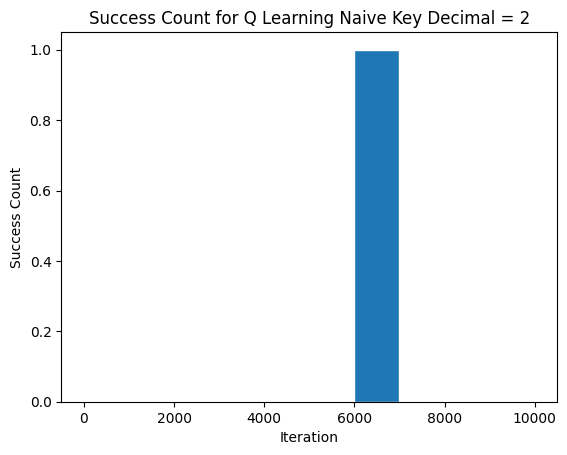

In [5]:
# naive key decimal = 2
summary, success_step = q_learning(10000, naiveKey, 2, 0.5, 5000, 0.3, 0.5, 0.1, False)
plot_success_hist(success_step, [0,10000], "Q Learning Naive Key Decimal = 2")

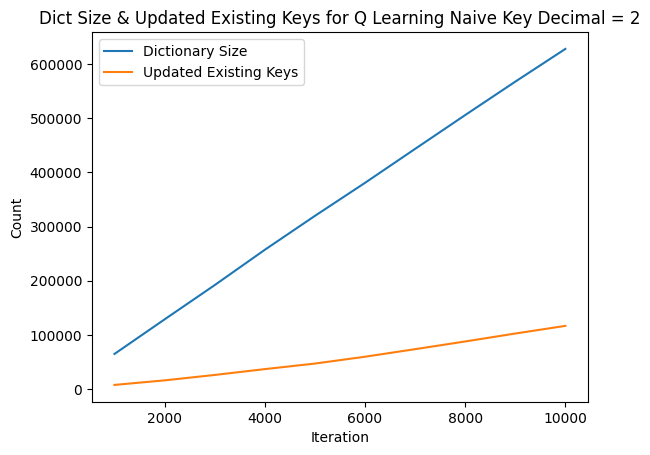

In [6]:
# naive key decimal = 2
p, s, d, u, it = extract_summary(summary)
plot_dic(d,u,it, "Q Learning Naive Key Decimal = 2")

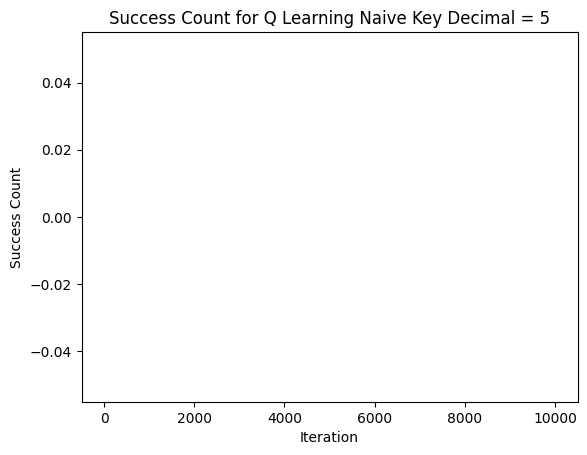

In [7]:
# naive key decimal = 5
summary, success_step = q_learning(10000, naiveKey, 5, 0.5, 5000, 0.3, 0.5, 0.1, False)
plot_success_hist(success_step, [0,10000], "Q Learning Naive Key Decimal = 5")

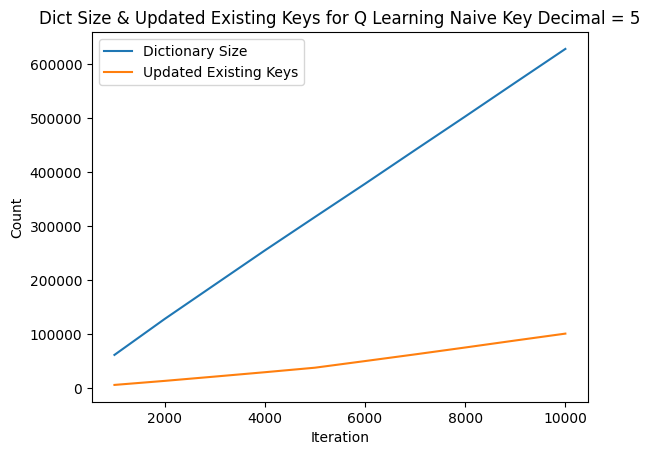

In [8]:
# naive key decimal = 5
p, s, d, u, it = extract_summary(summary)
plot_dic(d,u,it, "Q Learning Naive Key Decimal = 5")

From the graphs above, we can see that the dictionary size for both tests increases to over 600000 after 10000 times of iterations yet the existing keys/values have been updated only about 100000 times. We would need to find another effective way to store and update the Q values.

### Model 1 Rev 1: Q Learning with Divide Key
We could use other ways to partition the states. From the documentation in Gymnasium (n.d.), the range of x and y coordinates is from -1.5 to 1.5, the speed is from -5 to 5, and the angle is from -3.14 to 3.14. The speed has a larger range than the x and y coordinates, and thus different partition methods should be used. Therefore, a function called Divide Key is created which takes the number of partitions that should be applied to x and y coordinates, speed and angle, and returns the key with the transformed values. For example, if the x coordinate has been divided into 4 parts and the original x is 0.6, the new transformed x is 0.75.

Next, we are going to explore the Q learning using Divide Key with partitions (10, 20, 20) and (10, 30, 40).

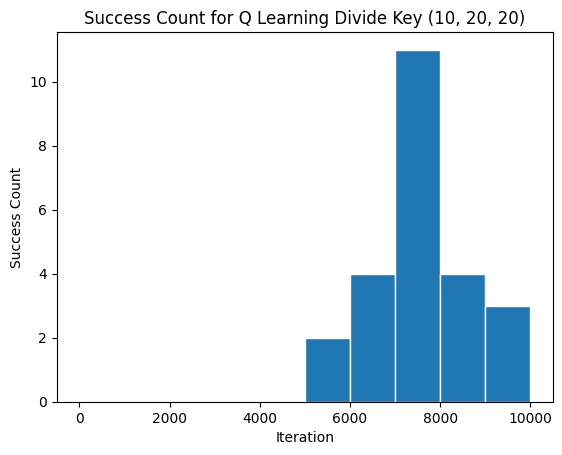

In [9]:
# divide key (10, 20, 20)
summary, success_step = q_learning(10000, divideKey, [10, 20, 20], 0.5, 5000, 0.3, 0.5, 0.1, False)
plot_success_hist(success_step, [0,10000],"Q Learning Divide Key (10, 20, 20)")

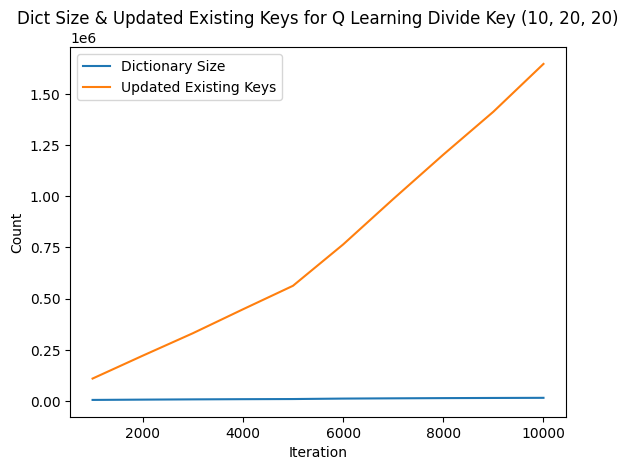

In [10]:
# divide key (10, 20, 20)
p, s, d, u, it = extract_summary(summary)
plot_dic(d, u, it, "Q Learning Divide Key (10, 20, 20)")

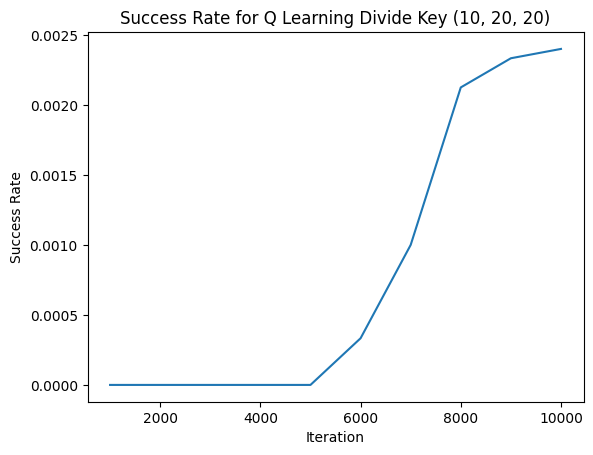

In [11]:
# divide key (10, 20, 20) 
plot_success_rate(s, it, "Q Learning Divide Key (10, 20, 20)")

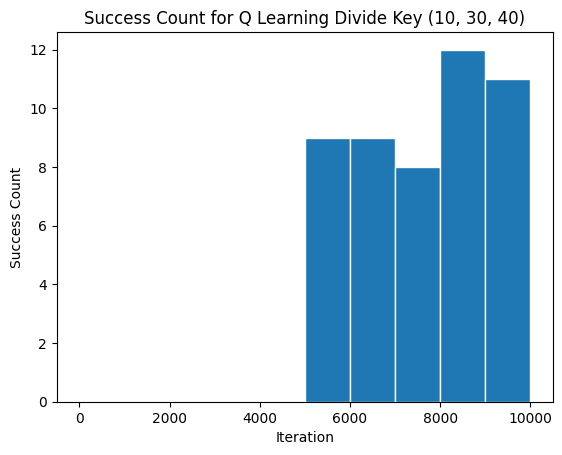

In [12]:
# divide key (10, 30, 40)
summary, success_step = q_learning(10000, divideKey, [10, 30, 40], 0.5, 5000, 0.3, 0.5, 0.1, False)
plot_success_hist(success_step, [0,10000], "Q Learning Divide Key (10, 30, 40)")

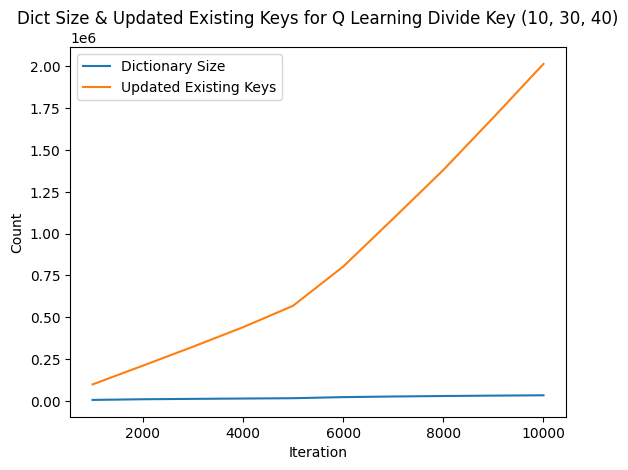

In [13]:
# divide key (10, 30, 40)
p, s, d, u, it = extract_summary(summary)
plot_dic(d, u, it, "Q Learning Divide Key (10, 30, 40)")

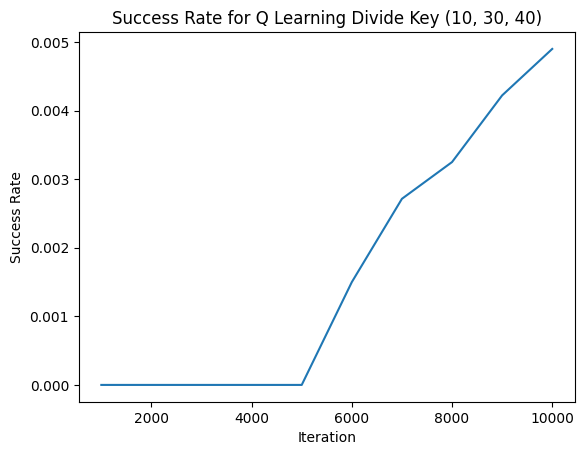

In [14]:
# divide key (10, 30, 40) 
plot_success_rate(s, it, "Q Learning Divide Key (10, 30, 40)")

From the results above, we can see that it seems that the success rate of the Divide Key has improved compared to the Naive Key. In the divide key model, the size of the Q value dictionary is much lower than the times that the existing key has been updated, which is extremely different from the naive key model where the size of the Q value dictionary is much higher than the times that the existing key has been updated. In other words, the possibility of each key/value in the Q value dictionary has been updated at least once is higher in the Divide Key model, which may be the reason why we start to have success plays. Also, it is interesting to see that the success rate starts to increase around 5000 iterations, which could be resulted from the design of our algorithm where the epsilon rate changes from 0.5 to 0.3 after 5000 iterations. In order to increase the success rate, perhaps we should go back to the documentation and see if there are concepts that we have not been paying attention to.

### Model 1 Rev 2: Q Learning with Conditional Statement

The version history in in Gymnasium (n.d.) mentions that the player gets 10 reward points if either of the leg lands on the ground and loses 10 points if it loses contact. Therefore, it would be logical to stay still if any of the legs has contacted the surface. Thus, we have added a conditional statement in the Q-learning function which overwrites the best action to 0 (i.e., do nothing) when a leg touches the ground.

Next, we are going to look at how this conditional statement would impact the examples we have tested. Here are the Naive Key with decimal=2 and decimal=5.

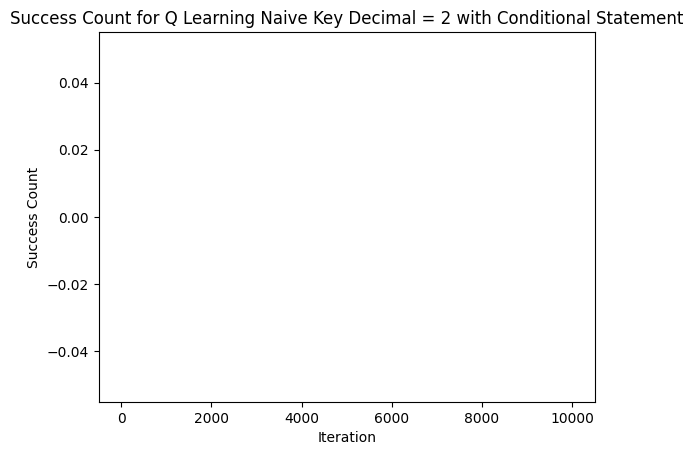

In [15]:
# naive key decimal = 2 with conditional statement
summary, success_step = q_learning(10000, naiveKey, 2, 0.5, 5000, 0.3, 0.5, 0.1, True)
plot_success_hist(success_step, [0,10000], "Q Learning Naive Key Decimal = 2 with Conditional Statement")

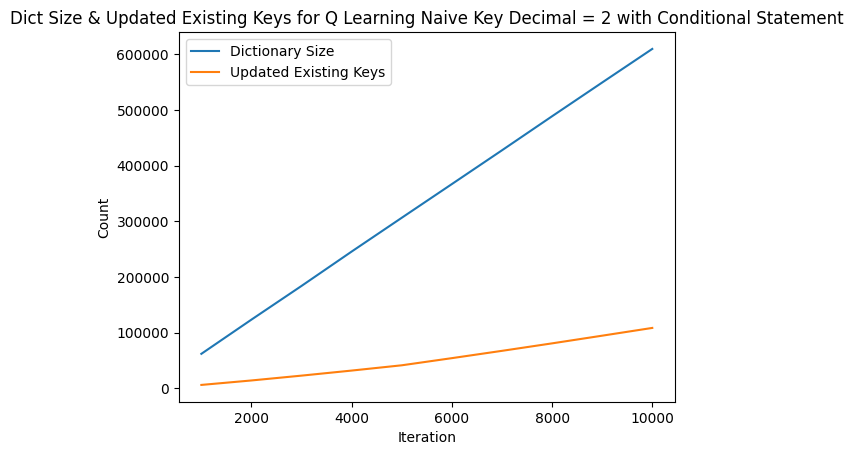

In [16]:
# naive key decimal = 2 with conditional statement
p, s, d, u, it = extract_summary(summary)
plot_dic(d,u,it, "Q Learning Naive Key Decimal = 2 with Conditional Statement")

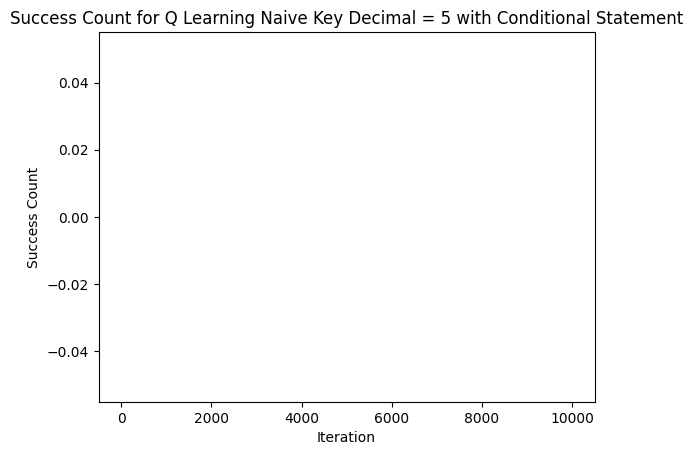

In [17]:
# naive key decimal = 5 with conditional statement
summary, success_step = q_learning(10000, naiveKey, 5, 0.5, 5000, 0.3, 0.5, 0.1, True)
plot_success_hist(success_step, [0,10000], "Q Learning Naive Key Decimal = 5 with Conditional Statement")

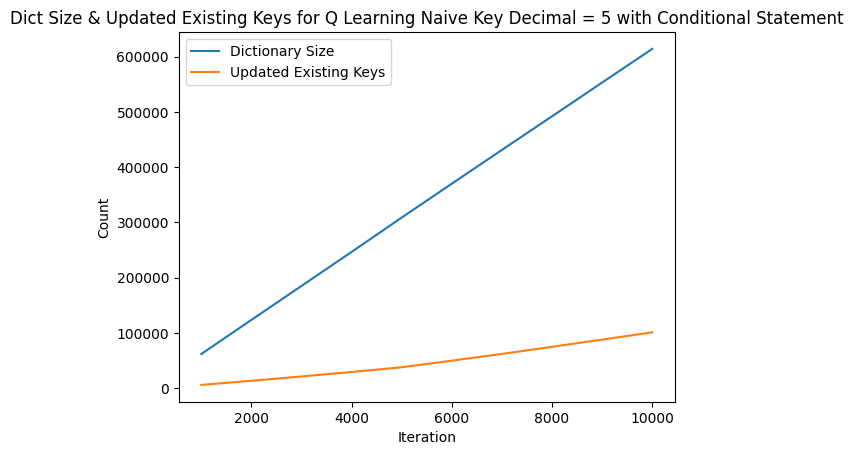

In [18]:
# naive key decimal = 5 with conditional statement
p, s, d, u, it = extract_summary(summary)
plot_dic(d,u,it, "Q Learning Naive Key Decimal = 5 with Conditional Statement")

From the plots above, the Naive Key still does poorly in winning the game. The dictionary size is still much larger than the number of updates of the existing keys/value. The Naive Key is still not ideal to save and update the Q values efficiently even after adding the conditional statement. Now, we revisit the Divide Key examples we have tried.

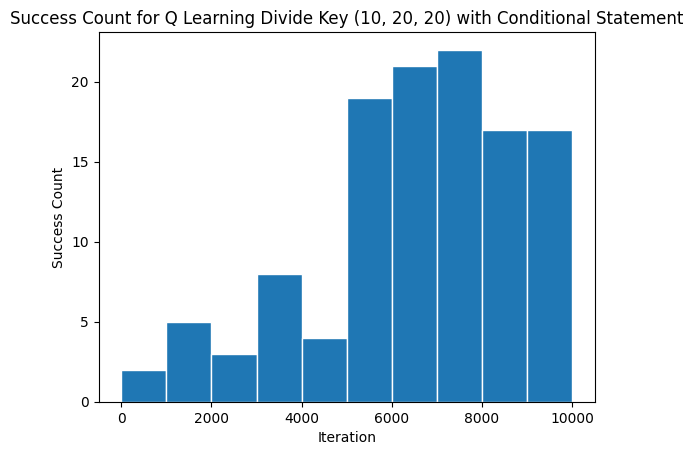

In [19]:
# divide key (10, 20, 20) with conditional statement
summary, success_step = q_learning(10000, divideKey, [10, 20, 20], 0.5, 5000, 0.3, 0.5, 0.1, True)
plot_success_hist(success_step, [0,10000], "Q Learning Divide Key (10, 20, 20) with Conditional Statement")

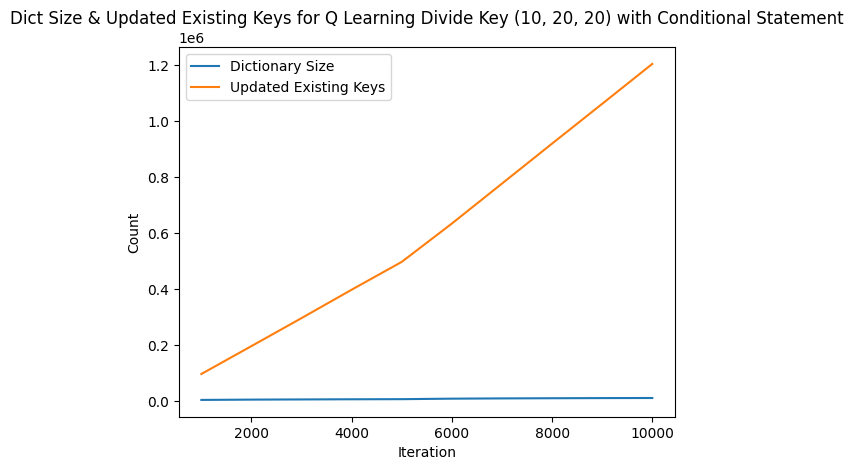

In [20]:
# divide key (10, 20, 20) with conditional statement
p, s, d, u, it = extract_summary(summary)
plot_dic(d, u, it, "Q Learning Divide Key (10, 20, 20) with Conditional Statement")

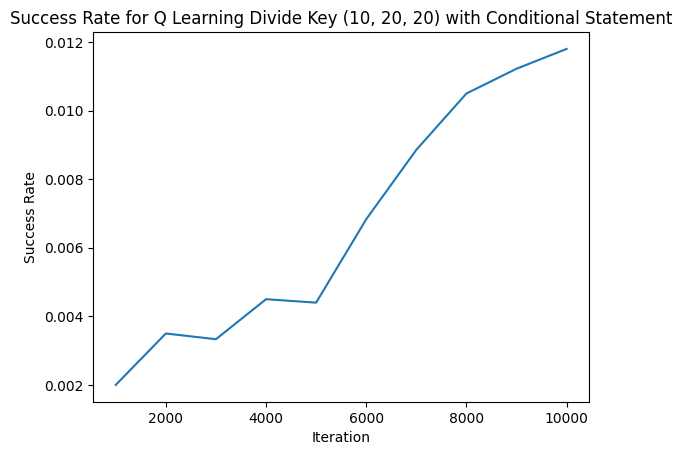

In [21]:
# divide key (10, 20, 20) with conditional statement
plot_success_rate(s,it,"Q Learning Divide Key (10, 20, 20) with Conditional Statement")

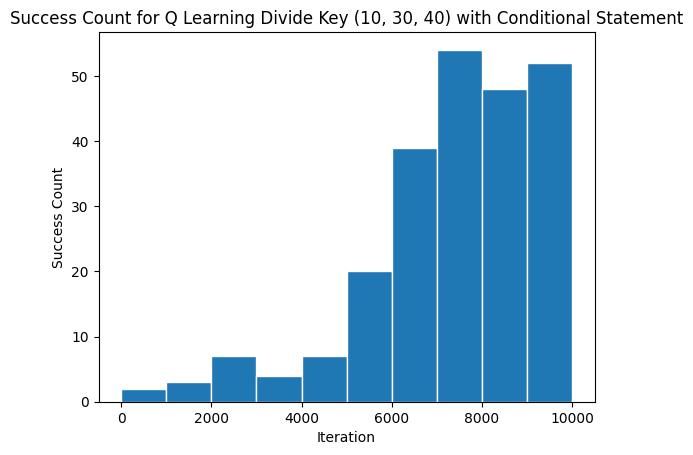

In [22]:
# divide key (10, 30, 40) with conditional statement
summary, success_step = q_learning(10000, divideKey, [10, 30, 40], 0.5, 5000, 0.3, 0.5, 0.1, True)
plot_success_hist(success_step, [0,10000],"Q Learning Divide Key (10, 30, 40) with Conditional Statement")

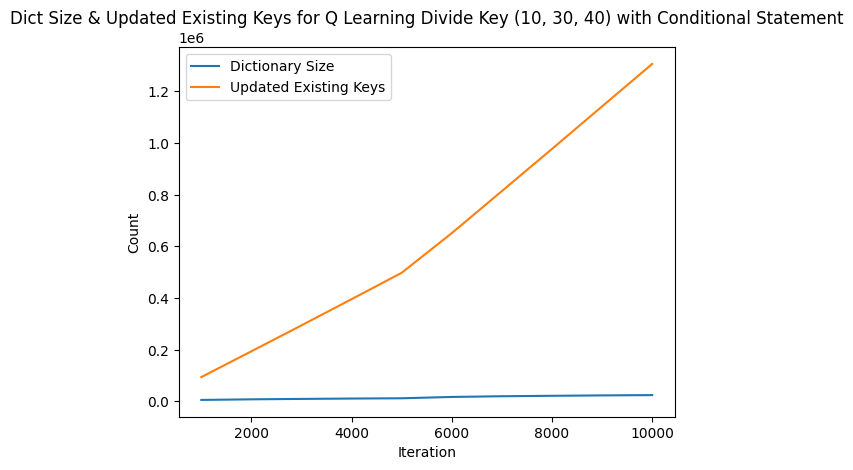

In [23]:
# divide key (10, 30, 40) with conditional statement
p, s, d, u, it = extract_summary(summary)
plot_dic(d, u, it, "Q Learning Divide Key (10, 30, 40) with Conditional Statement")

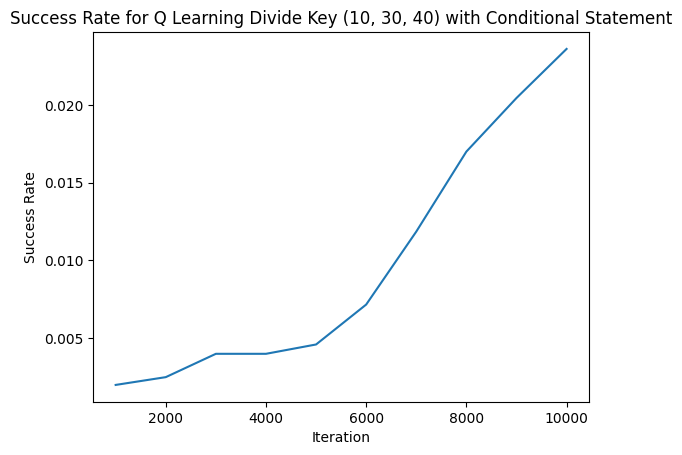

In [24]:
# divide key (10, 30, 40) with conditional statement
plot_success_rate(s, it, "Q Learning Divide Key (10, 30, 40) with Conditional Statement")

The links of two success plays of the Q Learning with Divide Key (10, 30, 40) and Conditional Statement are listed below.

A good landing
https://drive.google.com/file/d/12a_UmbQmfQzDt7xv9e5Xh-xTlilgCnXP/view?usp=sharing

A cool landing
https://drive.google.com/file/d/1--FVcd330v9Ja11jQK9UNHCpZNFApjkc/view?usp=sharing

From the plots above, we can see that the success rate of the Divide Key (10, 20, 20) has grown to over 1.1% after 10000 iterations and the success rate achieves 2% for Divide Key (10, 30, 40). The conditional statement seems to make a difference in Q Learning with the Divide Key model, especially the (10, 30, 40) case. The slope of the success rate seems to be growing after 10000 iterations, and therefore we would like to see how the success rate would be after 100000 iterations.   

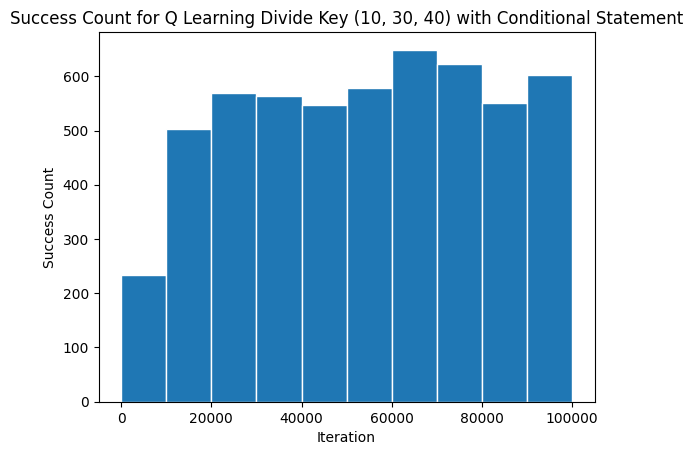

In [25]:
# divide key (10, 30, 40) with conditional statement and 100000 iterations
summary, success_step = q_learning(100000, divideKey, [10, 30, 40], 0.5, 5000, 0.3, 0.5, 0.1, True)
plot_success_hist(success_step, [0,100000],"Q Learning Divide Key (10, 30, 40) with Conditional Statement")

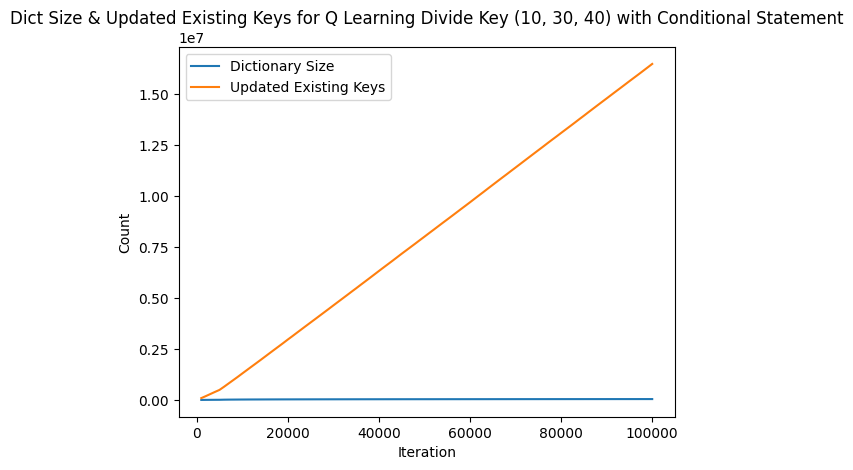

In [26]:
# divide key (10, 30, 40) with conditional statement and 100000 iterations
p, s, d, u, it = extract_summary(summary)
plot_dic(d, u, it, "Q Learning Divide Key (10, 30, 40) with Conditional Statement")

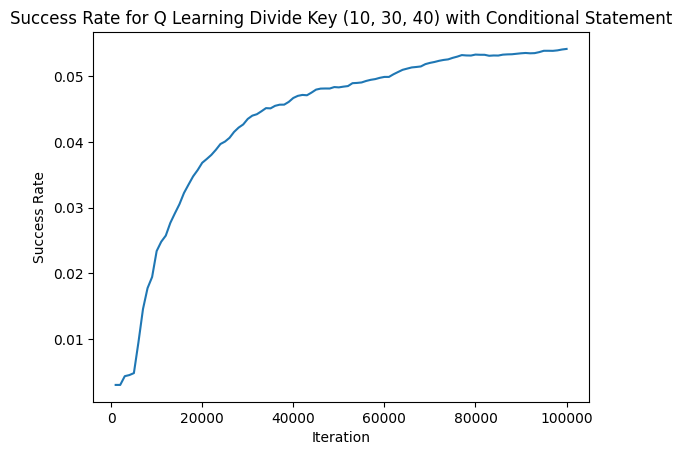

In [27]:
# divide key (10, 30, 40) with conditional statement and 100000 iterations
plot_success_rate(s, it, "Q Learning Divide Key (10, 30, 40) with Conditional Statement")

From the plot above, the success rate for Q Learning with Divide Key (10, 30, 40) and conditional statement slows down after reaching 5%, which implies that improving the success rate by longer training might not be effective for this model. This could be a result of the limited size of the dictionary. We can see that the number of existing key updates increases with the number of iterations, yet the size of dictionary is still rather small, which is not a good sign because in Q Learning, the Q values are learned by visiting states (Russell & Norvig, 2021). Since it is difficult to experience all states, we would need a better model to make some estimation for the Q values so that the agent would know to make a rather good action in unfamiliar situations, which according to Russell & Norvig (2021), the Approximate Q Learning would be a good option.

### Model 2 Rev 0 : Approximate Q Learning with Naive Function
Based on Russell & Norvig (2021), we can use a weighted linear combination of functions to estimate the Q values. Since there are 8 different elements in each state and 2 other features (i.e., fire main engine and side engine) that impacts the rewards, each of them can be a function in the linear combination and the formula for calculating the Q value for the Naive Function is shown below:

$Q(s,a)=w_1f_1+w_2f_2+w_3f_3+w_4f_4+w_5f_5+w_6f_6+w_7f_7+w_8f_8+w_9f_9+w_{10}f_{10}$ 

, where $f_1$ calculates the distance to the pad (0, 0) in x coordinate, $f_2$ calculates the distance to the pad (0, 0) in y coordinate, $f_3$ calculates the speed in x coordinate, $f_4$ calculates the speed in y coordinate, $f_5$ calculates the angle of the lander, $f_6$ calculates the speed of the angle, $f_7$ represents if leg 1 is on the grounds, $f_8$ represents if leg 2 is on the ground, $f_9$ represents if main engine is activated, and $f_{10}$ represents if either of the side engines is activated.

Below are the code/functions for this model.


In [28]:
# naive functions for approximate Q learning

def f1(obs, action):
    '''
    This function is a part of naive functions for approximate Q learning which takes a given observation state 
    and action and returns the distance to pad (0,0) in x axis

    :param object obs: the observation
    :param int action: the action

    '''
    x = obs[0]
    if action == 3 and x < 0:
        x -= 0.1
    elif action == 1 and x > 0:
        x += 0.1
    if action == 3 and x > 0:
        x += 0.1
    elif action == 1 and x < 0:
        x -= 0.1
    
    return abs(x)

def f2(obs, action):
    '''
    This function is a part of naive functions for approximate Q learning which takes a given observation state 
    and action and returns the distance to pad (0,0) in y axis

    :param object obs: the observation
    :param int action: the action

    '''
    y = abs(obs[1])

    # do nothing => go down
    if action == 0:
        y -= 0.1
    # fire main engine => go up
    elif action == 2:
        y += 0.1
    else:
        y -= 0.08

    return y

def f3(obs, action):
    '''
    This function is a part of naive functions for approximate Q learning which takes a given observation state 
    and action and returns the speed in x axis

    :param object obs: the observation
    :param int action: the action

    '''
    vx = obs[2]

    if action == 3 and vx < 0:
        vx -= 0.1

    elif action == 1 and vx > 0:
        vx += 0.1

    return abs(vx)

def f4(obs, action):
    '''
    This function is a part of naive functions for approximate Q learning which takes a given observation state
    and action and returns the speed in y axis

    :param object obs: the observation
    :param int action: the action

    '''
    vy = obs[3]

    if action == 0:
        vy -= 0.1
    elif action == 2:
        vy += 0.1
        
    return abs(vy)

def f5(obs, action):
    '''
    This function is a part of naive functions for approximate Q learning which takes a given observation state 
    and action and returns the angle of the lander

    :param object obs: the observation
    :param int action: the action

    '''
    angle = abs(obs[4])
    angleV = abs(obs[5])

    if action == 1 and angleV >= 0.03:
        angle += 0.003

    elif action == 3 and angleV >= 0.03:
        angle += 0.003

    elif action == 2 and angleV >= 0.03:
        angle += 0.002


    return angle

def f6(obs, action):
    '''
    This function is a part of naive functions for approximate Q learning which takes a given observation state 
    and action and returns the angle speed

    :param object obs: the observation
    :param int action: the action

    '''
    angleV = abs(obs[5])
    if action == 2:
        angleV += 0.04

    return angleV

def f7(obs, action):
    '''
    This function is a part of naive functions for approximate Q learning which takes a given observation state 
    and action and returns a boolean value that shows if leg 1 is on ground

    :param object obs: the observation
    :param int action: the action

    '''
    leg1 = obs[6]

    return leg1

def f8(obs, action):
    '''
    This function is a part of naive functions for approximate Q learning which takes a given observation state 
    and action and returns a boolean value that shows if leg 2 is on ground

    :param object obs: the observation
    :param int action: the action

    '''
    leg2 = obs[7]

    return leg2

def f9(obs, action):
    '''
    This function is a part of naive functions for approximate Q learning which takes a given observation state 
    and action and returns a boolean value that shows if main engine is activated

    :param object obs: the observation
    :param int action: the action

    '''
    used = 0
    if action == 2:
        used = 1

    return used

def f10(obs, action):
    '''
    This function is a part of naive functions for approximate Q learning which takes a given observation state 
    and action and returns a boolean value that shows if any of the side engine is activated

    :param object obs: the observation
    :param int action: the action

    '''
    used = 0
    if action == 1 or action == 3:
        used = 1

    return used

In [29]:
# combined functions for approximate Q learning

def f1_distance(obs, action):
    '''
    This function is a part of combined functions for approximate Q learning which takes a given observation state 
    and action and returns the distance to pad (0,0)

    :param object obs: the observation
    :param int action: the action

    '''
    x = obs[0]
    vx = obs[2]

    if action == 3 and x < 0:
        x -= 0.1
    
    elif action == 1 and x > 0:
        x += 0.1
    
    elif action == 1 and x < 0:
        x -= 0.1
    
    elif action == 3 and x > 0:
        x += 0.1
    
    elif action == 0:
        if x < 0 and vx < 0:
            x -= abs(vx)*0.01
        elif x > 0 and vx > 0:
            x += abs(vx)*0.01

    return abs(x)

# This function has referenced to Urone & Hinrichs (2022)
def f2_speed(obs, action):
    '''
    This function is a part of combined functions for approximate Q learning which takes a given observation state 
    and action and returns the speed to the ground

    :param object obs: the observation
    :param int action: the action

    '''
     # position x
    vx = obs[2]

    if action == 3 and vx < 0:
        vx += 0.01

    elif action == 1 and vx > 0:
        vx -= 0.01

    elif action == 3 and vx > 0:
        vx -= 0.01

    elif action == 1 and vx < 0:
        vx += 0.01
    # position y
    vy = obs[3]
    angle = obs[4]

    if action == 2:
        if vy <= -1.2 and angle < 1.2:
            vy += 1
        else:
            vy += 0.03

    else:
        vy -= 0.03
    
    speed = (vx**2 + vy**2)**(1/2)

    return speed

def f3_angle(obs, action):
    '''
    This function is a part of combined functions for approximate Q learning which takes a given observation state 
    and action and returns the angle of the lander

    :param object obs: the observation
    :param int action: the action

    '''
    angle = obs[4]
    angleV = abs(obs[5])

    if action == 1 and angle > 0:
        if angleV > 1.5:
            angle += 0.1
        elif angleV > 1:
            angle += 0.05
        elif angleV > 0.5:
            angle += 0.04
        elif angleV > 0.2:
            angle += 0.02
        elif angleV >= 0.03:
            angle += 0.01
    
    elif action == 1 and angle < 0:
        if angleV > 1.5:
            angle -= 0.1
        elif angleV > 1:
            angle -= 0.05
        elif angleV > 0.5:
            angle -= 0.04
        elif angleV > 0.2:
            angle -= 0.02
        elif angleV >= 0.03:
            angle -= 0.01

    elif action == 3 and angle > 0:
        if angleV > 1.5:
            angle += 0.1
        elif angleV > 1:
            angle += 0.05
        elif angleV > 0.5:
            angle += 0.04
        elif angleV > 0.2:
            angle += 0.02
        elif angleV >= 0.03:
            angle += 0.01
    
    elif action == 3 and angle < 0:
        if angleV > 1.5:
            angle -= 0.1
        elif angleV > 1:
            angle -= 0.05
        elif angleV > 0.5:
            angle -= 0.04
        elif angleV > 0.2:
            angle -= 0.02
        elif angleV >= 0.03:
            angle -= 0.01

    elif action == 2:
        if angleV > 0.2:
            angle += 0.02
        elif angleV >= 0.03:
            angle += 0.002

    elif action == 0 and angleV >= 0.03:
        angle += 0.01


    return angle

def f4_leg1(obs, action):
    '''
    This function is a part of combined functions for approximate Q learning which takes a given observation state 
    and action and returns a boolean value that shows if leg 1 is on ground

    :param object obs: the observation
    :param int action: the action

    '''
    return obs[6]

def f5_leg2(obs, action):
    '''
    This function is a part of combined functions for approximate Q learning which takes a given observation state 
    and action and returns a boolean value that shows if leg 1 is on ground

    :param object obs: the observation
    :param int action: the action

    '''
    return obs[7]

def f6_main(obs, action):
    '''
    This function is a part of combined functions for approximate Q learning which takes a given observation state 
    and action and returns a boolean value that shows if main engine is activated

    :param object obs: the observation
    :param int action: the action

    '''
    used = 0
    if action == 2:
        used = 1

    return used

def f7_side(obs, action):
    '''
    This function is a part of combined functions for approximate Q learning which takes a given observation state 
    and action and returns a boolean value that shows if any of the side engine is activated

    :param object obs: the observation
    :param int action: the action

    '''
    used = 0
    if action == 1 or action == 3:
        used = 1

    return used


In [30]:
# Functions for Approximate Q Learning

# This function has referenced to the Approximate Learning Algorithm in Russell & Norvig (2021)
def calculateQ_naive(obs, action, w):
    '''
    This method is based on Approximated Q learning algorithm in Russell & Norvig (2021) that returns the q value 
    for approximate Q Learning with naive functions

    :param object obs: the state observation
    :param int action: the action
    :param list w: the list contains the weights for all naive functions

    '''

    q = f1(obs, action) * w[0] +f2(obs, action) * w[1] + f3(obs, action) * w[2] +  f4(obs, action) * w[3] + f5(obs, action) * w[4] 
    + f6(obs, action) * w[5] + f7(obs, action) * w[6] + f8(obs, action) * w[7] + f9(obs, action) * w[8] + f10(obs, action) * w[9]

    return q

# This function has referenced to the Approximate Learning Algorithm in Russell & Norvig (2021) 
def calculateQ_combine(obs, action, w):
    '''
    This method is based on Approximated Q learning algorithm in Russell & Norvig (2021) that returns the q value 
    for approximate Q Learning with combined functions

    :param object obs: the state observation
    :param int action: the action
    :param list w: the list contains the weights for all naive functions

    '''

    q = f1_distance(obs, action) * w[0] +f2_speed(obs, action) * w[1] + f3_angle(obs, action) * w[2] +  f4_leg1(obs, action) * 10 
    + f5_leg2(obs, action) * 10 + f6_main(obs, action) * (-0.1) + f7_side(obs, action) * (-0.03)

    return q

# This function has referenced to the Approximate Learning Algorithm in Russell & Norvig (2021) and the sample code in Gymnasium (n.d.) and Towers et al. (2024).
def approx_q(iter, cal_Q_fun, weights, discount, alpha, success_score):
    '''
    This method is based on Approximated Q learning algorithm in Russell & Norvig (2021) and the sample code in Gymnasium (n.d.) and Towers et al. (2024)
    that takes various parameters and returns a tuple that has two dictionaries and a list, which are the summary of the games, the success game information
    and the final weights, respectively. 

    :param int iter: the number that this function iterates
    :param string cal_q_fun: the type function that will be used to calculate the q values, "n" for naive and "c" for combined
    :param list weights: the list of inital weights for q value calculation
    :param float discount: the discount value
    :param float alpha: the alpha value
    :param success_score: the score that identifies as success
    '''

    env = gym.make("LunarLander-v2", continuous=False, gravity=-10.0, enable_wind = False,
               wind_power = 10.0, turbulence_power = 1.5)
    
    total_reward = 0.0
    total_rounds = 0
    total_steps = 0
    total_success = 0
    # list to store weights
    w_vector = weights
    negInfinity = -math.inf
    discount = discount
    alpha = alpha
     # dictionary to save the summary of all plays
    summary = dict()
    # dictionary to save all successful plays
    success_step = dict()
    # start env
    obs = env.reset(seed=0)[0]


    while total_rounds < iter:

        bestAction = []
        total_steps += 1

        highestQ = negInfinity

        # loop thru all possible actions for Q(s,a) and find the max value and the corresponding action
        for i in range(4):
            # select naive or combine q 
            if cal_Q_fun == "n":
                q = calculateQ_naive(obs, i, w_vector)
            elif cal_Q_fun == "c":
                q = calculateQ_combine(obs, i, w_vector)

            if q > highestQ:
                highestQ = q
                bestAction = []
                bestAction.append(i)
            
            elif q == highestQ:
                bestAction.append(i)
        

        action = random.choice(bestAction)

        nextObs, reward, terminated, trunc, info = env.step(action)
        
        # update the total reward
        total_reward += reward


        # when the game is still ongoing
        if not terminated or trunc:
            
            # find maxQ(s', a')
            highestQ2 = negInfinity
            for i in range(0,4):
                # select naive or combine q 
                if cal_Q_fun == "n":
                    q = calculateQ_naive(nextObs, i, w_vector)    
                elif cal_Q_fun == "c":
                    q = calculateQ_combine(nextObs, i ,w_vector)
                
                if q > highestQ2:
                    highestQ2 = q
            
            # find Q(s, a)
            if cal_Q_fun == "n":
                oldQ = calculateQ_naive(obs, action, w_vector)
            elif cal_Q_fun == "c":
                oldQ = calculateQ_combine(obs, action, w_vector)


            # diff = reward + discount * maxQ(s',a') - Q(s,a)
            difference = reward + (discount * highestQ2) - oldQ

            # update weights 
            if cal_Q_fun == "n":
                w_vector[0] = w_vector[0] + alpha * difference * f1(obs, action)
                w_vector[1] = w_vector[1] + alpha * difference * f2(obs, action)
                w_vector[2] = w_vector[2] + alpha * difference * f3(obs, action)
                w_vector[3] = w_vector[3] + alpha * difference * f4(obs, action)
                w_vector[4] = w_vector[4] + alpha * difference * f5(obs, action)
                w_vector[5] = w_vector[5] + alpha * difference * f6(obs, action)
                w_vector[6] = w_vector[6] + alpha * difference * f7(obs, action)
                w_vector[7] = w_vector[7] + alpha * difference * f8(obs, action)
                w_vector[8] = w_vector[8] + alpha * difference * f9(obs, action)
                w_vector[9] = w_vector[9] + alpha * difference * f10(obs, action)


            elif cal_Q_fun == "c":
                w_vector[0] = w_vector[0] + alpha * difference * f1_distance(obs, action)
                w_vector[1] = w_vector[1] + alpha * difference * f2_speed(obs, action)
                w_vector[2] = w_vector[2] + alpha * difference * f3_angle(obs, action)



            # change obs to nextObs
            obs = nextObs


        # when the game finishes (terminated or truncated)
        else:
            total_rounds += 1

            if total_reward >= success_score:
                total_success += 1
                success_step[total_rounds]=total_reward

            # restart game -- reset obs, total_reward and total_steps (per round)
            obs = env.reset(seed=0)[0]
            total_reward = 0
            total_steps = 0

            # record success and failure times every 1k rounds
            if total_rounds % 1000 == 0:
                key1 = str(total_rounds) + "_success_rate"
                key2 = str(total_rounds) + "_failure_rate"
                key3 = str(total_rounds) + "_summary"

                summary[key1] = total_success / total_rounds
                summary[key2] = (total_rounds - total_success) / total_rounds
                summary[key3] = "alpha: " + str(alpha) +", discount: " + str(discount)


    return (summary, success_step, w_vector)


Now, we test this model with 10000 iterations with $\alpha=0.1$, and the discount rate is 0.5. 

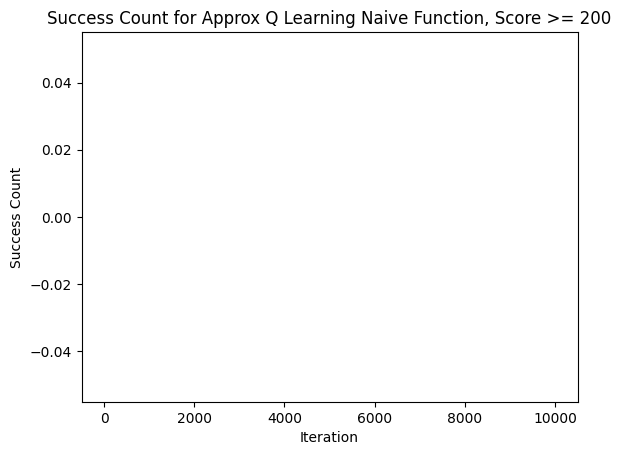

The final weights for Approx Q Learning Naive Function, Score >= 200:
-10.079784925049783
-10.000776566874361
12.612639560144252
2.036403432574687
-8.435022464092961
-585.4586029682424
763.528072533415
-4.498651546046457
-317.3809663144077
290.88504372140846


In [31]:
# Approx Q Learning Naive Function Score >= 200
summary, success_step, weights = approx_q(10000, "n", [-1,-1,-1,-1,-1,-1,-1,-1,10,10], 0.5, 0.1, 200)
plot_success_hist(success_step, [0, 10000],"Approx Q Learning Naive Function, Score >= 200")
print("The final weights for Approx Q Learning Naive Function, Score >= 200:")
for i in weights:
    print(i)

Unfortunately, there is no success play. Now we lower the success score from the default 200 points to 50 points.

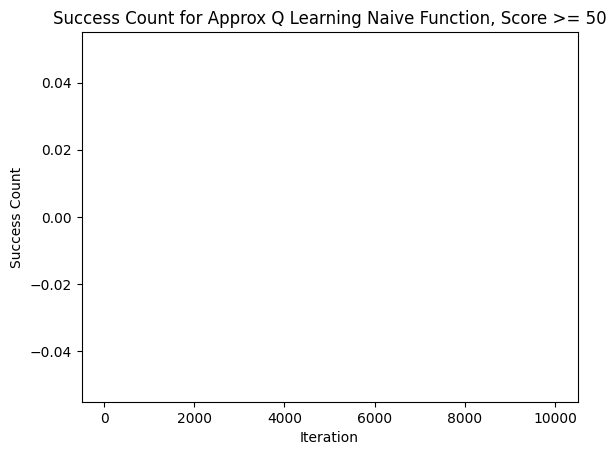

The final weights for Approx Q Learning Naive Function, Score >= 50:
-10.079784925049783
-10.000776566874361
12.612639560144252
2.036403432574687
-8.435022464092961
-585.4586029682424
763.528072533415
-4.498651546046457
-317.3809663144077
290.88504372140846


In [32]:
# Approx Q Learning Naive Function Score >= 50
summary, success_step, weights = approx_q(10000, "n", [-1,-1,-1,-1,-1,-1,-1,-1,10,10], 0.5, 0.1, 50)
plot_success_hist(success_step, [0, 10000],"Approx Q Learning Naive Function, Score >= 50")
print("The final weights for Approx Q Learning Naive Function, Score >= 50:")
for i in weights:
    print(i)

The Approximated Q Learning with Naive Function does not have any success games even when we lower the success score from the default 200 points to 50 points. The final weights do not seem to make any sense. For example, the $w_3$ and $w_4$ are positive numbers, which is odd because they are the coefficients of speed in x axis and speed in y axis, respectively. According to Gymnasium (n.d.), higher speed attracts deduction in rewards. The coefficients for speed in either axis should have negative signs. Also, $w_7$ and $w_8$ are the coefficients for leg 1 and leg 2 landing on the ground, and their value and direction (positive/negative) are vastly different. This is odd because they represent the same concept, and the values should not have differed this much. Moreover, it seems that we can use a fixed weight for some of the functions (e.g., fire main engine and leg 1 on ground). Maybe through simplifying the linear combination, we could have a better chance of getting the optimized model. Therefore, the Combined Function has been created to tackle this problem.

### Model 2 Rev 1 : Approximate Q Learning with Combined Function
The formula for calculating the Q value for the Combined Function is shown below:

$Q(s,a)=w_1f_1+w_2f_2+w_3f_2+10f_4+10f_5+(-0.1)f_6+(-0.03)f_7$ 

, where $f_1$ calculates the distance to the pad (0, 0), $f_2$ calculates the speed which is based on relative velocity in Urone & Hinrichs (2022), $f_3$ calculates the angle of the lander,  $f_4$ represents if leg 1 is on the ground, $f_5$ represents if leg 2 is on the ground, $f_6$ represents if the main engine is activated, and $f_7$ represents if either of the side engines is activated.

When we run 10000 times and use the default 200 points as the success score, there are no success plays. However, when we lower the success score to 50 points, there are some success cases.

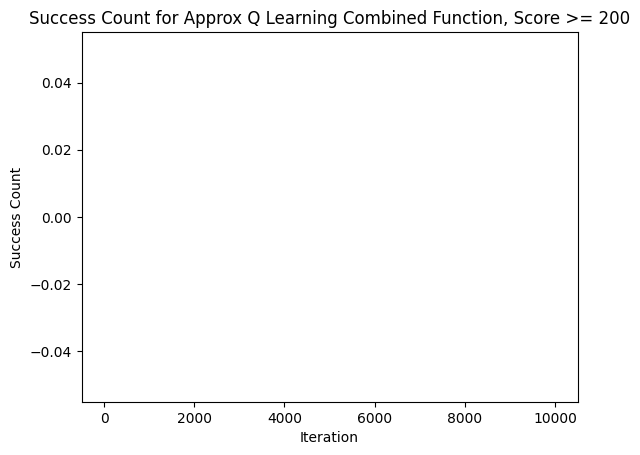

The final weights for Approx Q Learning Naive Function, Score >= 200:
15.86913513625353
0.4593233308840363
12.061021170630438


In [33]:
# Approx Q Learning Combined Function >= 200
summary, success_step, weights = approx_q(10000, "c", [1,1,1], 0.5, 0.1, 200)
plot_success_hist(success_step, [0, 10000],"Approx Q Learning Combined Function, Score >= 200")
print("The final weights for Approx Q Learning Naive Function, Score >= 200:")
for i in weights:
    print(i)

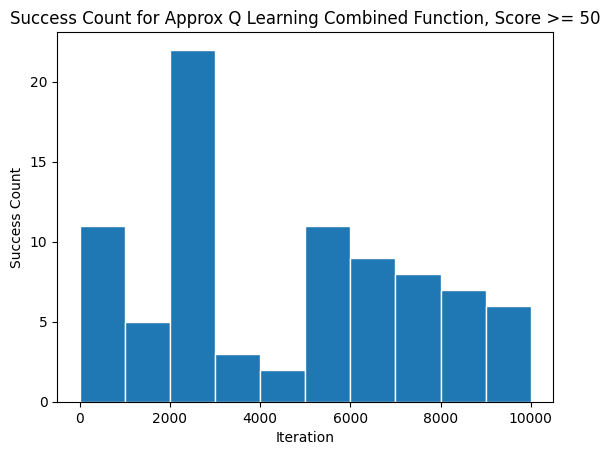

The final weights for Approx Q Learning Naive Function, Score >= 50:
6.712506721096648
6.704815824504117
24.986487367113984


In [34]:
# Approx Q Learning Combined Function >= 50
summary, success_step, weights = approx_q(10000, "c", [1,1,1], 0.5, 0.1, 50)
plot_success_hist(success_step, [0, 10000],"Approx Q Learning Combined Function, Score >= 50")
print("The final weights for Approx Q Learning Naive Function, Score >= 50:")
for i in weights:
    print(i)

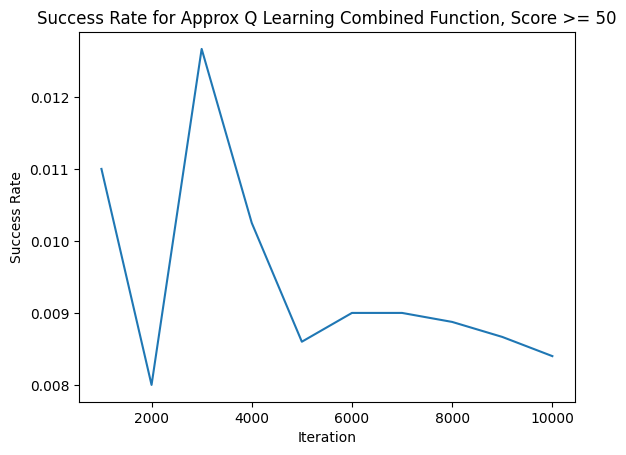

In [35]:
# Approx Q Learning Combined Function >= 50
p, s, d, u, it = extract_summary(summary)
plot_success_rate(s, it,"Approx Q Learning Combined Function, Score >= 50")

The final weights of the Combined Function model make it hard to explain why there are still plays that have positive points. We can see that all weights are positive, which seems to be a strange situation because the model favors a large distance and more tilted angle away from the pad (0, 0). Based on the rewarding rule in Gymnasium (n.d.), deviating from the pad with a tilted angle causes reward deduction and not to mention that crashing the lander results in a deduction of 100 points. Thus, any large value in distance, speed and angle should be avoided because in order to have a safe landing, the distance and landing speed to the pad (0, 0) should be as small as possible, as well as the angle of the lander. In general, a model with positive weights should not have games ending with positive points. This implies that there is some kind of landing, but it is not ideal. How does the model do that? What kind of landing is that?

When looking at the landing video of this model, it seems like the model "learns" to fly to a small corner and uses it as a crash cushion to stop itself and therefore lands. A sample of this video can be accessed at this link: 
https://drive.google.com/file/d/1pr20bDEUWwXodCZb6wDUZKskUfzLUjOb/view?usp=sharing

This explains why the weights are positive and many games end with lower positive scores. In other words, the model finds an alternative way to land, and the linear combination is still missing important factors that would guide standard safe landing. 

![approxq_combined_land](approxq_combined_land.png)
![approxq_combined_land2](approxq_combined_land_2.png)


## Summary and Limitations

In this study, we explore five different variations of Q learning and Approximate Q Learning to safely land the Lunar Lander. The Q Learning with Divide Keys and Conditional Statement has a best success rate among all model and has the potential to achieve an optimal model. It is worthwhile to do more research about how to increase the size of the Q value dictionary either through different partitioning methods or some policy guidance. We can see that the main challenge for the Q Learning models is to store and update Q values effectively, especially for continuous value types.

On the other hand, the Approximated Q Learning with Combined Functions learns how to land in a nontraditional way and has its potential too. More research in Physics needs to be done to find the missing feature in its weighted linear combinations so that safe landing can be done in any situation. The relationship between angle and angular speed are not focused in this study, which can be valuable to investigate. 

## References


Gymnasium. (n.d.). *Lunar Lander.* Retrieved August 8, 2024, from https://gymnasium.farama.org/environments/box2d/lunar_lander/

Russell, S. J., & Norvig, P. (2021). *Artificial Intelligence: A Modern Approach* (4th ed.). Pearson.

Towers, M., Kwiatkowski, A., Terry, J., Balis J. U., Cola, G. D., Deleu, T., Goulão, M., Kallinteris, A., Krimmel, M., KG, A., Perez-Vicente, R., Pierré, A., Schulhoff, S., Tai, J. J., Tan, H., & Younis, O. G. (2024). *Gymnasium: A Standard Interface for Reinforcement Learning Environments.* 
https://doi.org/10.48550/arXiv.2407.17032 


Urone, P. P., & Hinrichs, R. (2022). *College Physics 2e* (2nd ed.). OpenStax. https://openstax.org/books/college-physics-2e/pages/1-introduction-to-science-and-the-realm-of-physics-physical-quantities-and-units